## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [2]:
import numpy as np
import pandas as pd

reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(type(reviews))
print(reviews.head())

<class 'pandas.core.frame.DataFrame'>
                                                   0
0  bromwell high is a cartoon comedy . it ran at ...
1  story of a man who has unnatural feelings for ...
2  homelessness  or houselessness as george carli...
3  airport    starts as a brand new luxury    pla...
4  brilliant over  acting by lesley ann warren . ...


In [3]:
# Renaming for convinience
reviews = reviews.rename(columns={0: 'review'})
y = Y

In [4]:
reviews.head()

,review
0,bromwell high is a cartoon comedy . it ran at ...
1,story of a man who has unnatural feelings for ...
2,homelessness or houselessness as george carli...
3,airport starts as a brand new luxury pla...
4,brilliant over acting by lesley ann warren . ...


In [5]:
labels.head()

,0
0,positive
1,negative
2,positive
3,negative
4,positive


In [6]:
# 1 -> positive, 0 -> negative
y.head()

,0
0,1
1,0
2,1
3,0
4,1


**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

In [28]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# We will use stopwords to filter out words without significant semantic meaning.
# It seems like all reviews are in english.
nltk.download('stopwords')
vecotrizer = CountVectorizer(max_features=10_000, stop_words=stopwords.words('english'))
X = vecotrizer.fit_transform(reviews["review"]).toarray()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bruger\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from sklearn.model_selection import train_test_split

X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train, X_validation, y_train, y_validation= train_test_split(X_, y_, test_size=.25, random_state=42)

In [9]:
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_validation.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (15000, 10000)
Validation set shape: (5000, 10000)
Test set shape: (5000, 10000)


**(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

In [10]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [11]:
# Reviews are split 50/50 when it comes to positive and negative reviews.
y.value_counts()

0    12500
1    12500
dtype: int64

In [12]:
# baseline accuracy
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.5013333333333333

In [13]:
# Each row in the data set has 10_000 columns. 
# The index of the column maps to a word such that 
# 0 -> word is not present, 1 -> word is present
# [0,0,0] -> word with index 0,1,2 is not present
# [1,0,1] -> word with index 0 (aaron) and 2 (abandoned) is present, while word with index 1 is not present
vecotrizer.get_feature_names_out()

array(['aaron', 'abandon', 'abandoned', ..., 'zoom', 'zorro', 'zu'],
      dtype=object)

**(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

In [14]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

network = tf.keras.Sequential([
    tf.keras.layers.Dense(units=100, input_dim=X.shape[1], activation='tanh'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

network.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005), metrics = ['accuracy'])

In [15]:
history = network.fit(X_train, y_train, 
                    epochs = 100, 
                    validation_data=(X_validation, y_validation),
                    callbacks = [callback])

Epoch 1/100
469/469 [==============================] - 8s 16ms/step - loss: 0.3334 - accuracy: 0.8561 - val_loss: 0.2921 - val_accuracy: 0.8768
Epoch 2/100
469/469 [==============================] - 7s 15ms/step - loss: 0.1516 - accuracy: 0.9405 - val_loss: 0.3326 - val_accuracy: 0.8750
Epoch 3/100
469/469 [==============================] - 7s 15ms/step - loss: 0.0816 - accuracy: 0.9694 - val_loss: 0.4184 - val_accuracy: 0.8720
Epoch 4/100
469/469 [==============================] - 8s 17ms/step - loss: 0.0331 - accuracy: 0.9894 - val_loss: 0.5963 - val_accuracy: 0.8728
Epoch 5/100
469/469 [==============================] - 9s 18ms/step - loss: 0.0152 - accuracy: 0.9956 - val_loss: 0.6708 - val_accuracy: 0.8722
Epoch 6/100
469/469 [==============================] - 8s 17ms/step - loss: 0.0097 - accuracy: 0.9976 - val_loss: 0.7693 - val_accuracy: 0.8712
Epoch 7/100
469/469 [==============================] - 8s 17ms/step - loss: 0.0115 - accuracy: 0.9963 - val_loss: 0.7883 - val_accuracy:

In [16]:
import matplotlib.pyplot as plt

def plot_results(history):
    plt.figure()
    plt.title("Learning curves")
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy loss")
    plt.plot(history.history['loss'], label = 'train')
    plt.plot(history.history['val_loss'], label = 'valid')
    plt.legend()
    plt.show()

    plt.figure()
    plt.title("Learning curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(history.history['accuracy'], label = 'train')
    plt.plot(history.history['val_accuracy'], label = 'valid')
    plt.legend()
    plt.show()

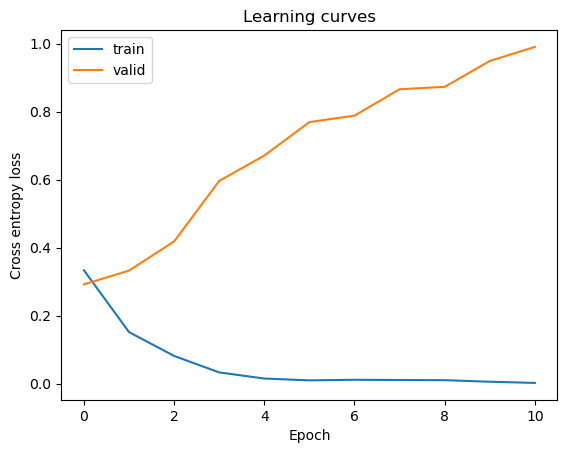

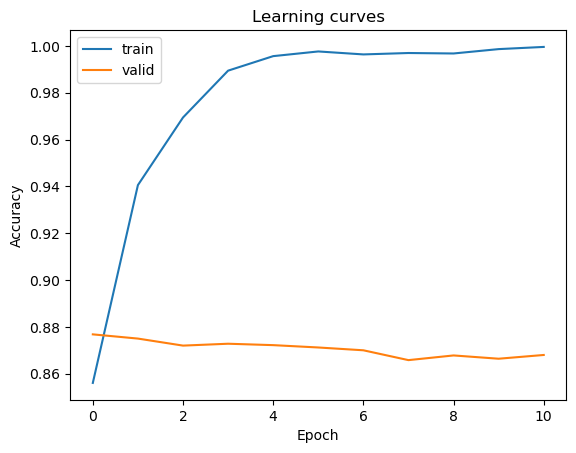

In [17]:
plot_results(history=history)

We notice significant overfitting, so we can try to regulularize, use dropout and experiment with the activation function.

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

network = tf.keras.Sequential([
    tf.keras.layers.Dense(units=100, input_dim=X.shape[1], activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

network.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005), metrics = ['accuracy'])

In [19]:
history = network.fit(X_train, y_train, 
                    epochs = 100, 
                    validation_data=(X_validation, y_validation),
                    callbacks = [callback])

Epoch 1/100
469/469 [==============================] - 12s 23ms/step - loss: 0.3352 - accuracy: 0.8548 - val_loss: 0.2921 - val_accuracy: 0.8790
Epoch 2/100
469/469 [==============================] - 9s 20ms/step - loss: 0.1586 - accuracy: 0.9367 - val_loss: 0.3199 - val_accuracy: 0.8792
Epoch 3/100
469/469 [==============================] - 9s 19ms/step - loss: 0.0821 - accuracy: 0.9687 - val_loss: 0.4376 - val_accuracy: 0.8744
Epoch 4/100
469/469 [==============================] - 9s 19ms/step - loss: 0.0440 - accuracy: 0.9836 - val_loss: 0.5730 - val_accuracy: 0.8676
Epoch 5/100
469/469 [==============================] - 10s 21ms/step - loss: 0.0208 - accuracy: 0.9931 - val_loss: 0.6902 - val_accuracy: 0.8712
Epoch 6/100
469/469 [==============================] - 10s 21ms/step - loss: 0.0109 - accuracy: 0.9974 - val_loss: 0.7600 - val_accuracy: 0.8700
Epoch 7/100
469/469 [==============================] - 9s 19ms/step - loss: 0.0062 - accuracy: 0.9987 - val_loss: 0.8673 - val_accura

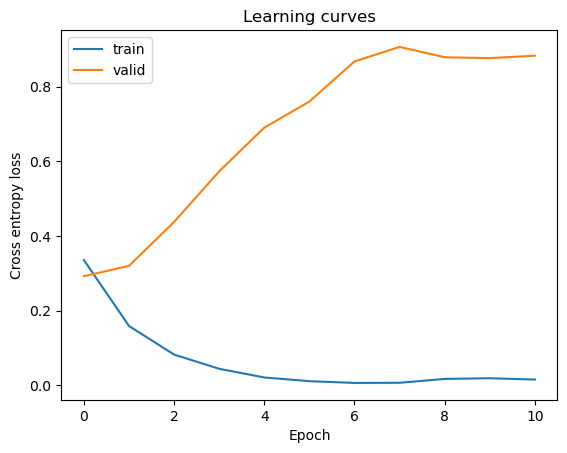

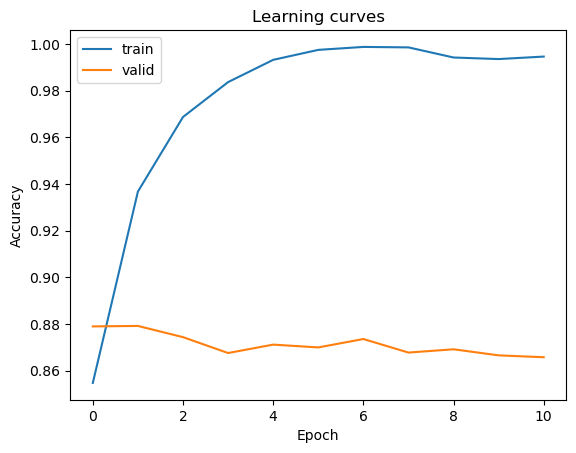

In [20]:
plot_results(history)

In [21]:
from tensorflow.keras import regularizers
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

network = tf.keras.Sequential([
    tf.keras.layers.Dense(units=100, input_dim=X.shape[1], kernel_regularizer=regularizers.l2(0.001),activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

network.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005), metrics = ['accuracy'])

In [22]:
history = network.fit(X_train, y_train, 
                    epochs = 100, 
                    validation_data=(X_validation, y_validation),
                    callbacks = [callback])

Epoch 1/100
469/469 [==============================] - 14s 26ms/step - loss: 0.7151 - accuracy: 0.8379 - val_loss: 0.7145 - val_accuracy: 0.8578
Epoch 2/100
469/469 [==============================] - 10s 21ms/step - loss: 0.7021 - accuracy: 0.8596 - val_loss: 0.6918 - val_accuracy: 0.8616
Epoch 3/100
469/469 [==============================] - 9s 19ms/step - loss: 0.6683 - accuracy: 0.8653 - val_loss: 0.6846 - val_accuracy: 0.8578
Epoch 4/100
469/469 [==============================] - 9s 18ms/step - loss: 0.6480 - accuracy: 0.8693 - val_loss: 0.6828 - val_accuracy: 0.8528
Epoch 5/100
469/469 [==============================] - 8s 18ms/step - loss: 0.6257 - accuracy: 0.8737 - val_loss: 0.6850 - val_accuracy: 0.8534
Epoch 6/100
469/469 [==============================] - 9s 20ms/step - loss: 0.6280 - accuracy: 0.8756 - val_loss: 0.6715 - val_accuracy: 0.8574
Epoch 7/100
469/469 [==============================] - 9s 20ms/step - loss: 0.6068 - accuracy: 0.8801 - val_loss: 0.6620 - val_accurac

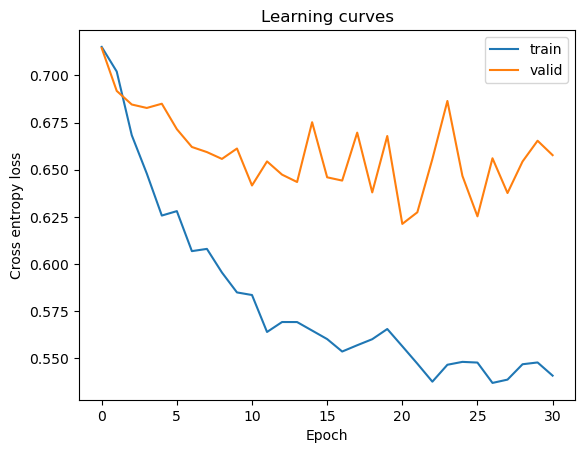

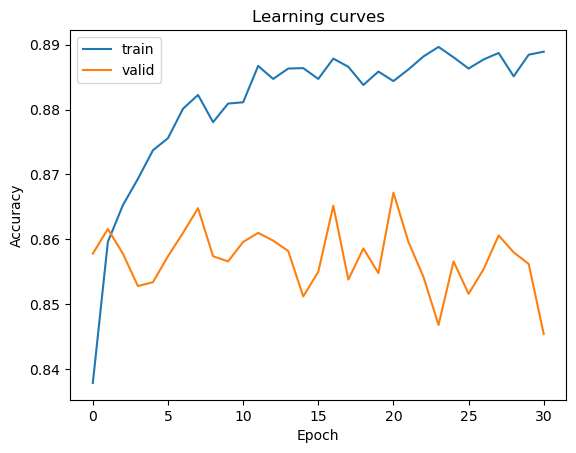

In [23]:
plot_results(history)

Less overfitting, but we don't see any real improvements on the validation set.

**(d)** Test your sentiment-classifier on the test set.

In [38]:
results = network.evaluate(X_test, y_test, batch_size=128)
print("test loss, test accuracy: ", results)

40/40 [==============================] - 0s 9ms/step - loss: 0.6361 - accuracy: 0.8560
test loss, test accuracy:  [0.63608717918396, 0.8560000061988831]


**(e)** Use the classifier to classify a few sentences you write yourselves. 

In [39]:
sentences = ['this movie is straight garbage!', 'brain dead director', 'greatest movie of all time!', 'gr8 movie, would watch again', 'great actors, decent plot, garbage writers. They should now never hire them again']
sentences_bags = vecotrizer.transform(sentences).toarray()

In [40]:
sentences_bags

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [41]:
network.predict(sentences_bags)

1/1 [==============================] - 0s 26ms/step


array([[0.3097869 ],
       [0.21260591],
       [0.78456366],
       [0.40694636],
       [0.29953942]], dtype=float32)